In [1]:
from numpy import *
from matplotlib.pylab import *
from tifmethods import *
%matplotlib inline


In [22]:
import sys
sys.path.append('..\\Nanorods')
from sub.subs import visualization, extractpeaks2d

In [2]:
folder='C:\\Users\\ludwig\\data\\'
file_wave='cell1_1.tif'

In [3]:
filecalib  = 'calib.tif'
dx, dy = calibfunction(filecalib)

NameError: name 'calibfunction' is not defined

In [106]:
dx, dy = 512,4

In [5]:
info=readtifInfo(folder+file_wave)

256 : 1024
257 : 512
258 : (16,)
262 : 1
270 : ImageJ=1.52i
images=6000
frames=6000
unit=micron
finterval=0.010014000000000002
loop=false
min=300.0
max=19463.0

273 : (6517240,)
277 : 1
278 : 512
50839 : _too long to print and to store_
279 : (1048576,)
50838 : _too long to print and to store_
282 : 1.0
283 : 1.0
296 : 1
254 : 0


In [164]:
TacqStr = [d for d in info[270].split('\n') if d.find('finterval')>=0][0].split('=')[-1]
#for d in info[270].split('\n'):
#    if d.find('finterval')>=0:
#        print(d.split('='))
#        TacqStr = d.split('=')[-1]
Tacq = float(TacqStr)
print(Tacq_wave)

0.010014000000000002


In [7]:
NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
Nframes = int(NframesStr)

In [8]:
repeat?

(6000,)


(0, 100)

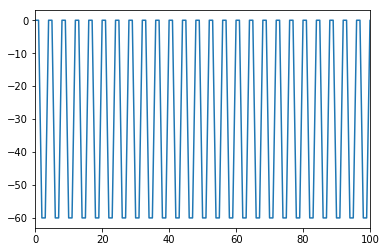

In [10]:
# Generating stimulation trace
Stim=tile([0, 0, -60, -60],Nframes//4);
print(Stim.shape)
plot(Stim)
xlim(0,100)

In [11]:
print(round(Nframes/7,2),Nframes//7)

857.14 857


In [ ]:
# reading wave movie

Movie=readBigTifFile(folder+file_wave)
print(Movie.shape)

In [13]:
SumMovie_wave=sum(Movie,axis=0); 
# Movie.sum(axis=0)

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2cc3cbef2b0>)

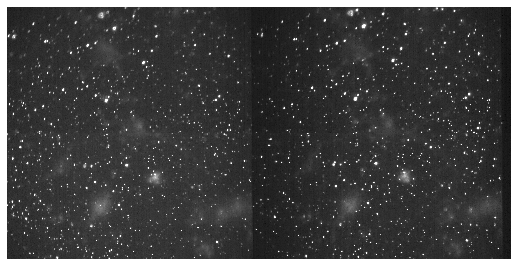

In [18]:
visualization(SumMovie_wave)

In [95]:
#LOading mask
finished = False
if finished:
    pass
else:
    Mask_CMOS = zeros((Movie.shape[1],Movie.shape[2]//2))
    Mask_CMOS[200:,200:] = 1
    Mask_CMOS[Mask_CMOS ==0] = nan

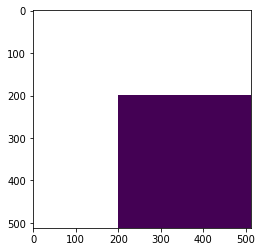

In [96]:
imshow(Mask_CMOS)

In [21]:
isnan(Mask_CMOS[0,0])

True

In [31]:
import cv2

def extractpeaks2d(img,kernel=7,width=None,height=None):
    if width is None or height is None:
        height, width = img.shape
    if type(kernel) is int:
        kernelm = cv2.UMat(ones((kernel,kernel),float32)/float(kernel)**2)
    elif type(kernel) is ndarray:
        kernelm = kernel
    else:
        print("Error kernel")
        return()
    dilated = cv2.dilate(img,kernel=kernelm)

    pos = arange(width*height)[dilated.flatten() == img.flatten()]
    prspctpeaks7 = img.flatten()[pos]
    sel = (-prspctpeaks7).argsort()
    #                          x                y : imA[y,x]
    posA = column_stack((pos[sel]%width,pos[sel]//width))
    return(posA)

In [97]:
#SE = strel('square',5);
kernel = 5
km = ones((kernel,kernel),float32)#/float(kernel)**2
J = zeros(Mask_CMOS.shape)
rs2 = ROIsize//2
mx,my = Mask_CMOS.shape

for x in range(0,mx-ROIsize):
    for y in range(0,my-ROIsize):
        temp = km*SumMovie_wave[x:(x+kernel),y:(y+kernel)]
        J[x+rs2,y+rs2] = temp.max()

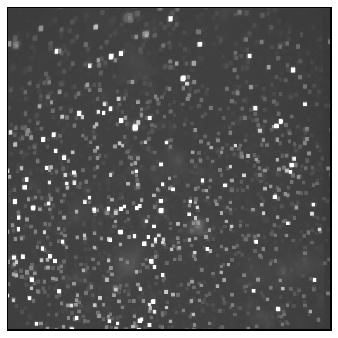

In [98]:
fig1 = visualization(J)

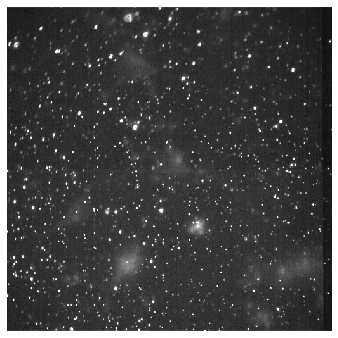

In [99]:
fig2 = visualization(imA)

In [143]:
#Mask_CMOS(Mask_CMOS==0)=nan;
mx,my = Mask_CMOS.shape
pts = [] 
for x in range(2*ROIsize+1,mx-2*ROIsize):
    for y in range(2*ROIsize,my-2*ROIsize):
        if ~isnan(Mask_CMOS[x,y]) and J[x, y]==SumMovie_wave[x, y]:
            pts.append([y, x])


pts = array(pts)

In [101]:
pts.shape

(2388, 2)

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2cdcf124f98>)

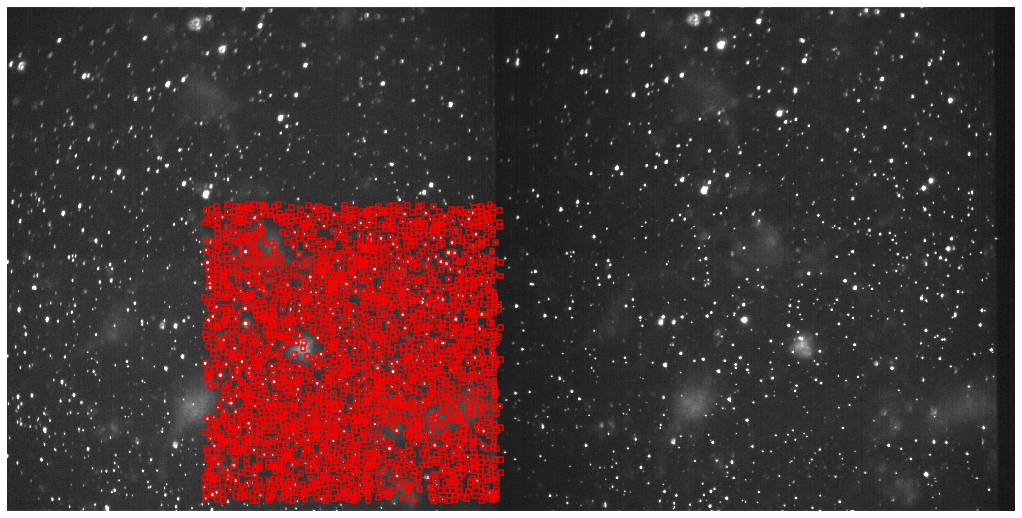

In [112]:
visualization(SumMovie_wave,pts,figsize=(14,14))

In [144]:
x=pts[:,0]+dx
y=pts[:,1]+dy

In [145]:
sel = x+floor(ROIsize/2)<SumMovie_wave.shape[1]
sel = sel*(y+floor(ROIsize/2)<SumMovie_wave.shape[0])
sel = sel*(y-floor(ROIsize/2)>0)
x = x[sel]
y = y[sel]

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2cdceeaa5c0>)

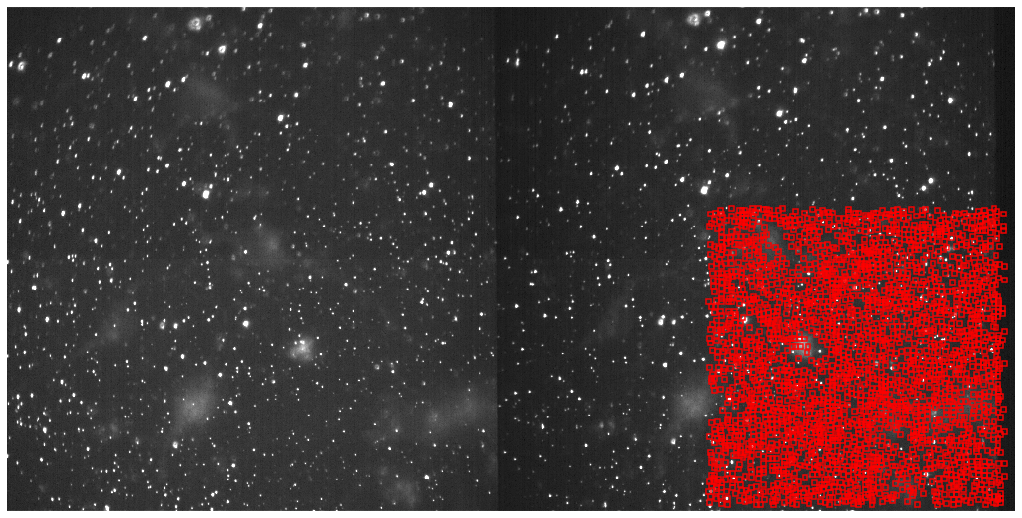

In [114]:
visualization(SumMovie_wave,column_stack((x,y)),figsize=(14,14))

In [146]:
pts_blue=column_stack((x-dx,y-dy))
pts_red=column_stack((x,y))

In [152]:
def centerROIs(img,pts,ROIsize = 5):
    rs2 = ROIsize//2
    ptsn = pts*1
    for i,p in enumerate(pts):
        x,y = p
        roi = img[(y-rs2):(y+rs2+1),(x-rs2):(x+rs2+1)]
        idx = roi.argmax()
        pxy, pxx = idx//5, idx%5
        ptsn[i,:] = [x+pxx-2,y+pxy-2]
    return(ptsn)

In [153]:
centerROIs(SumMovie_wave,pts_red)

array([[737, 206],
       [759, 206],
       [764, 206],
       ...,
       [944, 507],
       [960, 503],
       [993, 504]])

In [170]:
NROI_auto=pts_blue.shape[0]
rs2 = ROIsize//2
Nframes = Movie.shape[0]
signal=zeros((Nframes, NROI_auto))
for i,p in enumerate(pts_blue):
    x=p[0]
    y=p[1]
    roi = Movie[:,(y-rs2):(y+rs2+1),(x-rs2):(x+rs2+1)]
    lin_roi=roi.reshape(Nframes,ROIsize**2)
    lin_roi.sort(axis=1)
    back=lin_roi[:,:ROIsize];
    sig=lin_roi[:,ROIsize:];
    signal[:,i]=(sig.sum(axis=1)-back.mean(axis=1)*(ROIsize**2-ROIsize))/Tacq

    
        #Signal_auto_2ch=Signal_auto(:,1:NROI_auto)+Signal_auto(:,NROI_auto+1:end);

(6000, 2388)
[[56221.29019373 32055.12282804 32953.86458957 42041.14240064
  36648.69183144]
 [44437.78709806 36049.53065708 30557.21989215 26063.51108448
  31056.52087078]]


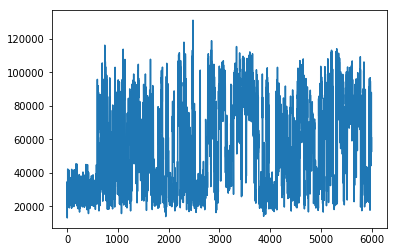

In [176]:
print(signal.shape)
print(signal[:2,:5])
plot(signal[:,randint(2000)])

In [203]:
def linearsig(Movie,pts,ROIsize=5):
    # Add tacq
    NROI_auto=pts.shape[0]
    rs2 = ROIsize//2
    Nframes = Movie.shape[0]
    signal=zeros((Nframes, NROI_auto))
    for i,p in enumerate(pts):
        x=p[0]
        y=p[1]
        roi = Movie[:,(y-rs2):(y+rs2+1),(x-rs2):(x+rs2+1)]
        lin_roi=roi.reshape(Nframes,ROIsize**2)
        lin_roi.sort(axis=1)
        back=lin_roi[:,:ROIsize];
        sig=lin_roi[:,ROIsize:];
        signal[:,i]=(sig.sum(axis=1)-back.mean(axis=1)*(ROIsize**2-ROIsize))
    return(signal)
    

In [178]:
signal_blue = linearsig(Movie,pts_blue,ROIsize=5)

In [180]:
signal_red = linearsig(Movie,pts_red,ROIsize=5)

In [183]:
signal_2ch=signal_blue+signal_red

In [187]:
temp1=signal_2ch.mean(axis=0)
temp2=mean((signal_2ch-temp1)**2, axis=0)
temp3=mean((signal_2ch-temp1)**3,axis=0)/temp2**(3.0/2.0)
temp4=mean((signal_2ch-temp1)**4, axis=0)/temp2**(4.0/2.0)
classifier=(temp3**2+1)/temp4

In [196]:
ROI_selected=classifier>0.45

if sum(ROI_selected)==0:
    print('no ROI selected')

NROI=ROI_selected.shape[0];
signal_blue_sel=signal_blue[:,ROI_selected]
signal_red_sel=signal_red[:,ROI_selected]

In [202]:
pts_blue_sel=pts_blue[ROI_selected,:];
pts_red_sel=pts_red[ROI_selected,:];

In [201]:
pts_blue.shape,pts_blue_sel.shape

((2388, 2), (183, 2))

In [205]:
folder='C:\\Users\\ludwig\\data\\'
file_wave='cell1_1.tif'
filecalib  = 'calib.tif'
#dx, dy = calibfunction(filecalib)

def signalext(file_wave,dx,dy, ROIsize = 5, kernel = 5 , recentering = False):

    info=readtifInfo(folder+file_wave)
    TacqStr = [d for d in info[270].split('\n') if d.find('finterval')>=0][0].split('=')[-1]
    Tacq = float(TacqStr)
    NframesStr = [d for d in info[270].split('\n') if d.find('frames')>=0][0].split('=')[-1]
    Nframes = int(NframesStr)

    # reading wave movie
    Movie=readBigTifFile(folder+file_wave)

    
    SumMovie_wave=sum(Movie,axis=0); 

    #LOading mask
    finished = False
    if finished:
        pass
    else:
        Mask_CMOS = zeros((Movie.shape[1],Movie.shape[2]//2))
        Mask_CMOS[200:,200:] = 1
        Mask_CMOS[Mask_CMOS ==0] = nan

    # Dilation to extract peaks inside mask
    km = ones((kernel,kernel),float32)#/float(kernel)**2
    J = zeros(Mask_CMOS.shape)
    rs2 = ROIsize//2
    mx,my = Mask_CMOS.shape
    for x in range(0,mx-ROIsize):
        for y in range(0,my-ROIsize):
            temp = km*SumMovie_wave[x:(x+kernel),y:(y+kernel)]
            J[x+rs2,y+rs2] = temp.max()
            
    mx,my = Mask_CMOS.shape
    pts = [] 
    for x in range(2*ROIsize+1,mx-2*ROIsize):
        for y in range(2*ROIsize,my-2*ROIsize):
            if ~isnan(Mask_CMOS[x,y]) and J[x, y]==SumMovie_wave[x, y]:
                pts.append([y, x])

    pts = array(pts)

    # CHecking borders of the movie after translation
    x=pts[:,0]+dx
    y=pts[:,1]+dy
    sel = x+floor(ROIsize/2)<SumMovie_wave.shape[1]
    sel = sel*(y+floor(ROIsize/2)<SumMovie_wave.shape[0])
    sel = sel*(y-floor(ROIsize/2)>0)
    x = x[sel]
    y = y[sel]

    pts_blue=column_stack((x-dx,y-dy))
    pts_red=column_stack((x,y))

    if recentering:
        pts_red = centerROIs(SumMovie_wave,pts_red)

    
    signal_blue = linearsig(Movie,pts_blue,ROIsize=5)/Tacq
    signal_red = linearsig(Movie,pts_red,ROIsize=5)/Tacq
    signal_2ch=signal_blue+signal_red

    #Classifier
    temp1=signal_2ch.mean(axis=0)
    temp2=mean((signal_2ch-temp1)**2, axis=0)
    temp3=mean((signal_2ch-temp1)**3,axis=0)/temp2**(3.0/2.0)
    temp4=mean((signal_2ch-temp1)**4, axis=0)/temp2**(4.0/2.0)
    classifier=(temp3**2+1)/temp4
    ROI_selected=classifier>0.45

    if sum(ROI_selected)==0:
        raise 'no ROI selected'

    NROI=ROI_selected.shape[0];
    signal_blue_sel=signal_blue[:,ROI_selected]
    signal_red_sel=signal_red[:,ROI_selected]
    pts_blue_sel=pts_blue[ROI_selected,:];
    pts_red_sel=pts_red[ROI_selected,:];
    
    return(signal_blue_sel,signal_red_sel,pts_blue_sel,pts_red_sel)